In [1]:
import pandas as pd
import datetime
import random
import pytz

from sqlalchemy import create_engine

from password import hoop_pwd
pwd = hoop_pwd.password

%matplotlib inline

from nba_seer import *

modules imported
functions defined


In [2]:
# create sql conn and load game stats logs ----------------------

conn = create_engine('mysql+pymysql://root:%s@118.190.202.87:3306/nba_stats' % pwd)
game_stats_logs = pd.read_sql_table('game_stats_logs', conn)
game_stats_logs = game_stats_logs[game_stats_logs['GAME_TYPE'] != 'all_star']

print(str(len(game_stats_logs)) + ' player stats loaded.')

185249 player stats loaded.


In [3]:
# load player list ----------------------

all_players = nba_py.player.PlayerList(season='2017-18').info()

print('players list loaded')

players list loaded


In [4]:
def get_score(row):
    player_id = row['PERSON_ID']
    game_id = row['GAME_ID']
    stats = game_stats_logs[(game_stats_logs['PLAYER_ID'] == player_id) & 
                            (game_stats_logs['GAME_ID'] == game_id)].copy()
    #print(stats)
    stats['SCO'] = stats['PTS'] * 1 + stats['AST'] * 1.5 + \
    stats['OREB'] * 1 + stats['DREB'] * 0.7 + \
    stats['STL'] * 2 + stats['BLK'] * 1.8 + stats['TO'] * -1 + \
    stats['FGM'] * 0.4 + (stats['FGA'] - stats['FGM']) * -1 + stats['FG3M'] * 0.5
    return stats['SCO'].max()

In [5]:
def test_result(players):
    diff_pct = players['SCO_DIFF_PCT'].describe().to_frame()
    diff_sco = players['SCO_DIFF'].describe().to_frame()
    ans = pd.concat([diff_sco, diff_pct], axis=1)
    return ans

In [6]:
def factor_cov(players):
    cov_diff = pd.DataFrame()
    #cov_diff['cov'] = abs(players[['MIN_COV_20', 'SCO_COV_20']].mean(axis = 1))
    cov_diff['cov'] = abs(players['MIN_COV_20'] * players['SCO_COV_20'])
    cov_diff['diff_pct'] = abs(players['SCO_DIFF_PCT'])
    cov_diff.plot(x='cov', y='diff_pct', kind='scatter', grid=True, figsize=(10, 7))
    cov_diff_pct_corr = cov_diff['cov'].corr(cov_diff['diff_pct'])
    print('the corr between cov and different percantage is: ', cov_diff_pct_corr)

In [7]:
def diff_distribution(players, rg, interval):
    diff_pct = players[abs(players['SCO_DIFF_PCT']) <= rg]['SCO_DIFF_PCT'].abs()
    bins = []
    for i in range(int(rg/interval)):
        bins.append(i*interval)
    pct_cut = pd.cut(diff_pct, bins)
    pct_cut_df = pd.value_counts(pct_cut).to_frame().rename(columns={'SCO_DIFF_PCT': 'count'})
    pct_cut_df = pct_cut_df.sort_index(axis=0)
    pct_cut_df.plot(kind='bar', figsize=(15, 7))
    print('data in range:', len(diff_pct)/len(players))

In [8]:
game_date = game_stats_logs['GAME_DATE_EST'].drop_duplicates().apply(lambda x: x[:10])

In [10]:
players = pd.DataFrame()
for i in random.sample(list(game_date), 5):
    j = datetime.datetime.strptime(i, "%Y-%m-%d").date()
    games = get_games(j)
    players = players.append(get_players_p(games, game_stats_logs))
    print(str(j) + ' complete!')
else:
    print(len(players), ' players total!')

2015-11-11 complete!
2013-10-08 complete!
2016-11-21 complete!
2017-01-12 complete!
2017-03-31 complete!
1132  players total!


In [11]:
players = get_exp_sco(players, game_stats_logs)

players['ACT_SCO'] = players.apply(get_score, axis = 1)
players['SCO_DIFF'] = players['EXP_SCO'] - players['ACT_SCO']
players['SCO_DIFF_PCT'] = players['SCO_DIFF'] / players['ACT_SCO']
print('test data loaded!')

5games days complete!
days rest complete!
ma20 complete!
ma10 complete!
ma5 complete!
min20 complete!
min10 complete!
min5 complete!
min_cov_20 complete!
sco_cov_20 complete!
sco cov less than 0 droped!
all done!
test data loaded!


In [12]:
players = players[(players['ACT_SCO'] != 0) & (players['ACT_SCO'].notnull())]

In [13]:
players.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
86,1627777,1610612754,HOME,0021600202,1610612744,14.0,331.0,12.09,1.90,3.92,7.45,5.22,5.68,0.880,1.803,1.01,-5.3,6.31,-1.190566
148,204014,1610612753,AWAY,0021600204,1610612749,9.0,332.0,14.93,10.93,14.42,12.78,11.37,13.33,0.315,1.025,4.66,-5.0,9.66,-1.932000
158,202068,1610612747,HOME,0011300018,1610612743,2.0,1472.0,28.40,28.40,28.40,13.50,13.50,13.50,0.471,0.120,10.65,-4.7,15.35,-3.265957
49,204038,1610612740,AWAY,0021600586,1610612751,11.0,281.0,18.27,19.36,16.20,22.06,20.54,18.64,0.331,0.615,10.17,-3.2,13.37,-4.178125
188,201145,1610612763,HOME,0021500120,1610612744,8.0,708.0,15.02,12.85,5.14,24.89,23.21,21.48,0.202,0.635,7.09,-2.6,9.69,-3.726923
146,203145,1610612744,AWAY,0011300017,1610612762,151.0,1471.0,8.63,16.02,7.77,3.84,3.68,6.23,0.904,2.138,1.38,-2.5,3.88,-1.552000
52,101107,1610612766,HOME,0021600201,1610612763,9.0,332.0,17.24,15.99,13.71,27.81,28.09,28.43,0.207,0.577,12.22,-2.4,14.62,-6.091667
101,203949,1610612744,AWAY,0021600202,1610612754,18.0,333.0,19.36,16.39,3.85,8.25,6.78,5.72,0.494,1.001,2.54,-2.3,4.84,-2.104348
206,203546,1610612744,AWAY,0021500120,1610612763,16.0,711.0,13.28,20.97,24.51,8.44,11.10,6.67,0.750,1.962,4.75,-2.3,7.05,-3.065217
141,1627775,1610612744,HOME,0021600590,1610612765,20.0,280.0,9.75,4.74,6.30,9.56,8.23,7.63,0.667,1.455,1.63,-2.0,3.63,-1.815000


In [14]:
players_t = players[players['5_g_d'] < 20]
players_t = players_t[players_t['SCO_COV_20'] < 0.6]
players_t = players_t[players_t['MIN_COV_20'] < 0.25]
players_t.sort_values('ACT_SCO')

,PERSON_ID,TEAM_ID,Location,GAME_ID,Against_Team_ID,5_g_d,d_rest,MA_20,MA_10,MA_5,MIN_20,MIN_10,MIN_5,MIN_COV_20,SCO_COV_20,EXP_SCO,ACT_SCO,SCO_DIFF,SCO_DIFF_PCT
52,101107,1610612766,HOME,0021600201,1610612763,9.0,332.0,17.24,15.99,13.71,27.81,28.09,28.43,0.207,0.577,12.22,-2.4,14.62,-6.091667
107,1891,1610612749,HOME,0021601130,1610612765,8.0,202.0,14.93,14.96,20.04,21.95,20.39,23.28,0.236,0.508,10.11,-1.8,11.91,-6.616667
142,202841,1610612744,AWAY,0011300017,1610612762,3.0,1471.0,48.75,48.75,48.75,6.00,6.00,6.00,0.236,0.236,8.12,-1.3,9.42,-7.246154
39,2207,1610612751,AWAY,0011300015,1610612764,10.0,1627.0,17.82,17.95,13.37,34.44,36.66,40.85,0.201,0.399,16.98,-1.0,17.98,-17.980000
90,203077,1610612766,HOME,0011300019,1610612737,9.0,1644.0,18.88,19.21,18.83,26.50,27.97,28.77,0.226,0.550,14.62,-0.2,14.82,-74.100000
214,203085,1610612746,HOME,0021600207,1610612761,8.0,332.0,14.32,15.32,15.09,24.30,21.86,20.51,0.212,0.584,9.20,0.6,8.60,14.333333
19,204038,1610612752,AWAY,0021500113,1610612766,9.0,707.0,23.67,24.75,22.07,29.36,27.21,28.92,0.147,0.435,18.60,0.8,17.80,22.250000
149,201571,1610612753,AWAY,0021600204,1610612749,9.0,332.0,19.73,21.15,23.18,18.22,19.18,20.68,0.248,0.456,11.48,0.9,10.58,11.755556
145,203484,1610612765,AWAY,0021600590,1610612744,10.0,280.0,21.14,21.06,22.81,35.46,37.95,39.84,0.147,0.426,22.72,1.0,21.72,21.720000
79,101145,1610612754,HOME,0021600202,1610612744,9.0,331.0,19.94,19.82,19.21,31.57,34.00,36.15,0.242,0.418,18.51,1.0,17.51,17.510000


In [15]:
test_result(players_t)

,SCO_DIFF,SCO_DIFF_PCT
count,305.000000,305.000000
mean,0.266426,0.302849
std,9.657369,5.166345
min,-31.840000,-74.100000
25%,-6.690000,-0.248958
50%,-0.100000,-0.022472
75%,8.210000,0.544444
max,29.590000,22.250000


the corr between cov and different percantage is:  0.15440205323


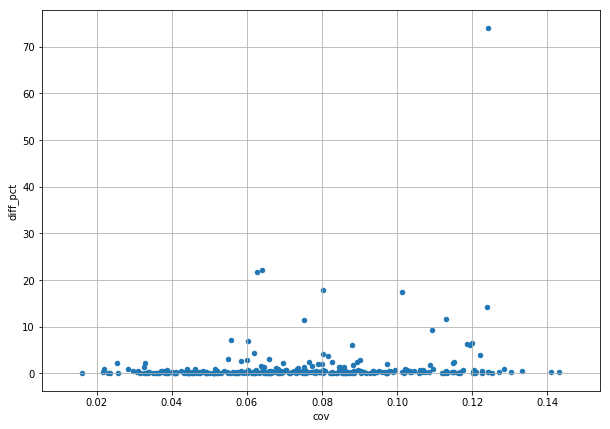

In [16]:
factor_cov(players_t)

data in range: 0.9508196721311475


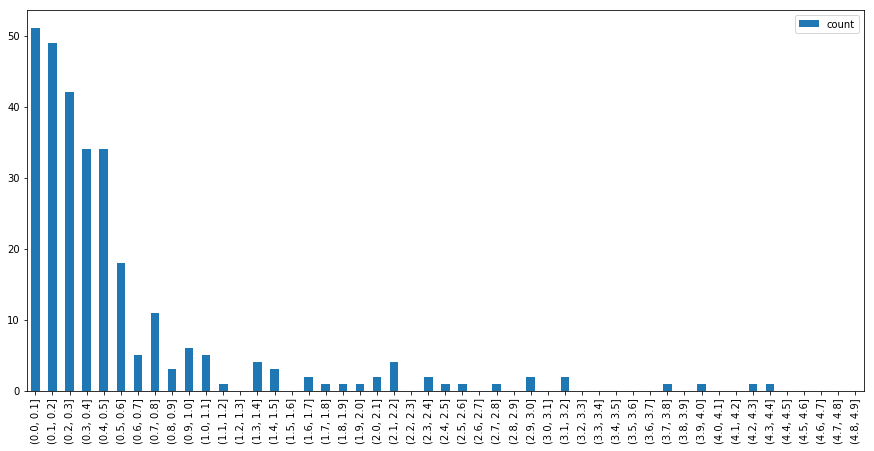

In [17]:
diff_distribution(players_t, 5, 0.1)